# BMNC SCML analysis

In [1]:
%%capture
from sc_spectrum.scml import rbf_neighbor_graph
from sc_spectrum.scml import sparse_spectral
from sc_spectrum.scml import scml
from sc_spectrum.scml import spectral_clustering
from sc_spectrum.scml import soft_scml

from sc_spectrum.bmnc.bmnc_preprocessing import preprocess_rna, preprocess_adt
from sc_spectrum.visualization import umap_embed, umap_scatter, recolor_clusters

In [2]:
from time import asctime, localtime

import numpy as np
import pandas as pd

import scipy
from scipy.sparse import csr_matrix
from scipy.sparse import diags
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import normalized_mutual_info_score

import torch

from typing import Tuple
from typing import List

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import seaborn as sns

plt.style.use('default')
rcParams['font.size'] = 11
rcParams['pdf.fonttype'] = 42
plt.rcParams.update({"text.color": 'k'})

In [3]:
use_gpu = True

if use_gpu and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


### Load Seurat output files

In [4]:
input_dir = "../../sc-spectrum-datasets/"

seurat_umap = pd.read_csv(input_dir + "seurat_v4_bm_umap_00.csv", index_col=0)
seurat_meta = pd.read_csv(input_dir + "seurat_v4_bm_meta_00.csv", index_col=0)

In [5]:
seurat_meta

,orig.ident,nCount_RNA,nFeature_RNA,nCount_ADT,nFeature_ADT,lane,donor,celltype.l1,celltype.l2,RNA.weight,ADT.weight,wsnn_res.2,seurat_clusters
a_AAACCTGAGCTTATCG-1,bmcite,7546,2136,1350,25,HumanHTO4,batch1,Progenitor cells,Prog_RBC,0.487299,0.512701,19,19
a_AAACCTGAGGTGGGTT-1,bmcite,1029,437,2970,25,HumanHTO1,batch1,T cell,gdT,0.245543,0.754457,10,10
a_AAACCTGAGTACATGA-1,bmcite,1111,429,2474,23,HumanHTO5,batch1,T cell,CD4 Naive,0.501680,0.498320,1,1
a_AAACCTGCAAACCTAC-1,bmcite,2741,851,4799,25,HumanHTO3,batch1,T cell,CD4 Memory,0.431308,0.568692,4,4
a_AAACCTGCAAGGTGTG-1,bmcite,2099,843,5434,25,HumanHTO2,batch1,Mono/DC,CD14 Mono,0.572097,0.427903,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
b_TTTGTCATCCGAGCCA-1,bmcite,3000,895,5403,25,HumanHTO8,batch2,T cell,CD4 Memory,0.296002,0.703998,7,7
b_TTTGTCATCCGTAGGC-1,bmcite,2230,649,4744,25,HumanHTO9,batch2,T cell,CD4 Naive,0.429453,0.570547,1,1
b_TTTGTCATCCTCGCAT-1,bmcite,4259,1457,6600,25,HumanHTO6,batch2,Mono/DC,CD16 Mono,0.506814,0.493186,18,18
b_TTTGTCATCGCCGTGA-1,bmcite,2648,733,4939,25,HumanHTO3,batch2,T cell,CD4 Naive,0.225718,0.774282,1,1


In [6]:
n_clust = len(np.unique(seurat_meta["wsnn_res.2"].values))
print(n_clust)

bmcite_rna_pca = preprocess_rna(input_dir + "seurat_wnn_bmcite_data_RNA_counts.csv", n_pc = 50, random_state = 12345678)

bmcite_adt_clr = preprocess_adt(input_dir + "seurat_wnn_bmcite_data_ADT_counts.csv")


40


In [7]:
bmcite_rna_pca.shape

(30672, 50)

### Spectral clustering

In [8]:
Gs_rna = rbf_neighbor_graph(bmcite_rna_pca.values.astype(np.float32), adaptive = True)

L_rna, w_rna, v_rna = sparse_spectral(Gs_rna, n_clust = n_clust)

cl_rna = spectral_clustering(v_rna, n_clust = n_clust)

In [9]:
Gs_adt = rbf_neighbor_graph(bmcite_adt_clr.values.astype(np.float32), adaptive = True)

L_adt, w_adt, v_adt = sparse_spectral(Gs_adt, n_clust = n_clust)

cl_adt = spectral_clustering(v_adt, n_clust = n_clust)

Text(0.5, 1.0, 'Graph Laplacian eigen spectrum for BMNC CITE-seq dataset')

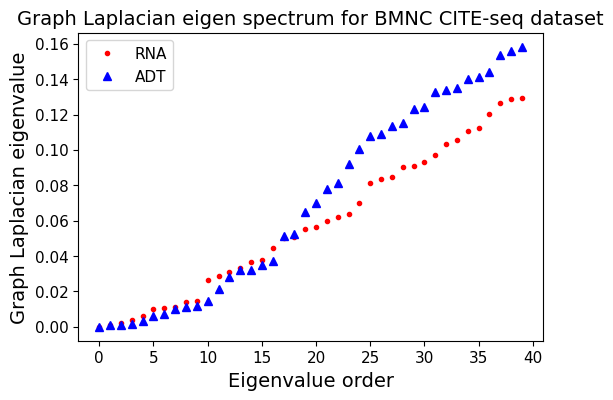

In [10]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

l1, = plt.plot(w_rna, 'r.')
l2, = plt.plot(w_adt, 'b^')

ax.legend(handles=[l1, l2], labels=["RNA", "ADT"])
ax.set_xlabel("Eigenvalue order", fontsize=14)
ax.set_ylabel("Graph Laplacian eigenvalue", fontsize=14)

ax.set_title("Graph Laplacian eigen spectrum for BMNC CITE-seq dataset", fontsize=14)

### Load SCML results

#### SCML results were obtained by running the following command in the sc-spectrum directory
    rna_file = " ../sc-spectrum-datasets/seurat_wnn_bmcite_data_RNA_counts.csv"
    rna_file = " ../sc-spectrum-datasets/seurat_wnn_bmcite_data_ADT_counts.csv"
    python src/sc_spectrum/bmnc/main_bmnc.py -f_rna rna_file -f_adt adt_file --nclust 40 --n_pc 50 --outdir ../sc-spectrum-datasets --alpha 0.1


In [11]:
cl_scml = np.load("../../sc-spectrum-datasets/bmnc_cluster_labels_0.1.npy")

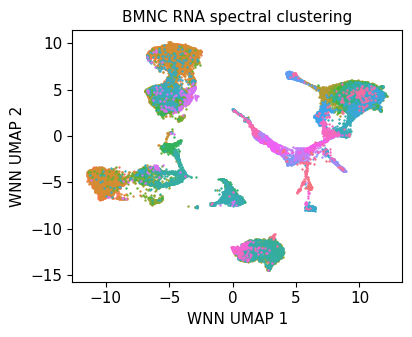

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(4.25, 3.5))

umap_scatter(ax, seurat_umap, cl_rna, show_labels = False, legend = False)

ax.set_xlabel("WNN UMAP 1", fontsize=11)
ax.set_ylabel("WNN UMAP 2", fontsize=11)
ax.set_title("BMNC RNA spectral clustering", fontsize = 11)

plt.tight_layout()
plt.savefig("../../sc-spectrum-figures/bmnc/figure-bmnc-rna-spectral-wnn-umap.pdf", format="pdf", transparent=True)

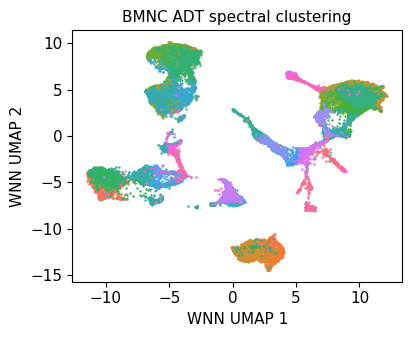

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4.25, 3.5))

umap_scatter(ax, seurat_umap, cl_adt, show_labels = False, legend = False)

ax.set_xlabel("WNN UMAP 1", fontsize=11)
ax.set_ylabel("WNN UMAP 2", fontsize=11)
ax.set_title("BMNC ADT spectral clustering", fontsize = 11)

plt.tight_layout()
plt.savefig("../../sc-spectrum-figures/bmnc/figure-bmnc-adt-spectral-wnn-umap.pdf", format="pdf", transparent=True)

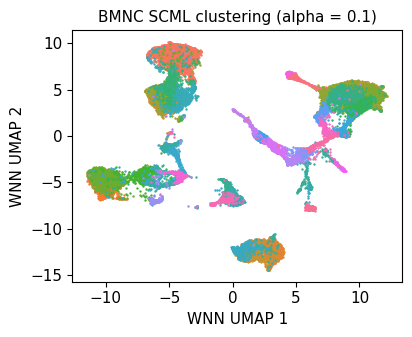

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(4.25, 3.5))

umap_scatter(ax, seurat_umap, cl_scml, show_labels = False, legend = False)

ax.set_xlabel("WNN UMAP 1", fontsize=11)
ax.set_ylabel("WNN UMAP 2", fontsize=11)
ax.set_title("BMNC SCML clustering (alpha = 0.1)", fontsize = 11)

plt.tight_layout()
plt.savefig("../../sc-spectrum-figures/bmnc/figure-bmnc-scml-a01-wnn-umap.pdf", format="pdf", transparent=True)

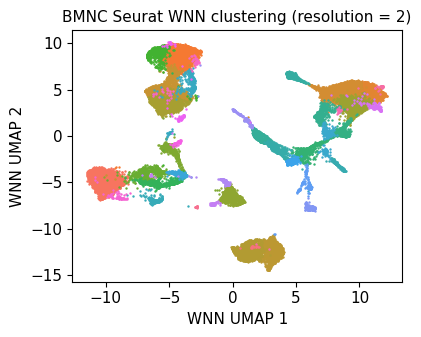

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(4.25, 3.5))

umap_scatter(ax, seurat_umap, seurat_meta["wsnn_res.2"], show_labels = False, legend = False)

ax.set_xlabel("WNN UMAP 1", fontsize=11)
ax.set_ylabel("WNN UMAP 2", fontsize=11)
ax.set_title("BMNC Seurat WNN clustering (resolution = 2)", fontsize = 11)

plt.tight_layout()
plt.savefig("../../sc-spectrum-figures/bmnc/figure-bmnc-wnn-res2-wnn-umap.pdf", format="pdf", transparent=True)

In [17]:
print("RNA-WNN = {}".format(normalized_mutual_info_score(cl_rna, seurat_meta["wsnn_res.2"])))
print("ADT-WNN = {}".format(normalized_mutual_info_score(cl_adt, seurat_meta["wsnn_res.2"])))


print("RNA-SCML = {}".format(normalized_mutual_info_score(cl_rna, cl_scml)))
print("ADT-SCML = {}".format(normalized_mutual_info_score(cl_adt, cl_scml)))

print("SCML-WNN NMI = {}".format(normalized_mutual_info_score(cl_scml, seurat_meta["wsnn_res.2"])))
print("RNA-ADT NMI = {}".format(normalized_mutual_info_score(cl_rna, cl_adt)))

RNA-WNN = 0.6296712927761968
ADT-WNN = 0.7515263108931305
RNA-SCML = 0.6671807738126966
ADT-SCML = 0.7444378003807898
SCML-WNN NMI = 0.7655038160855325
RNA-ADT NMI = 0.5672451241851325


In [18]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.neighbors import NearestNeighbors

In [19]:
def nn_corr(NN, features):
    
    correlations = np.zeros((features.shape[1], 2))

    for j in range(features.shape[1]):
        predicted = [features.iloc[:, j].values[NN[i, :]].mean() for i in range(NN.shape[0])]
        
        correlations[j, 0] = pearsonr(features.iloc[:, j].values, predicted)[0]
        correlations[j, 1] = spearmanr(features.iloc[:, j].values, predicted)[0]
        
    return correlations


def reconstruction_corr(A, features):
    
    correlations = np.zeros((features.shape[1], 2))
    D_1 = A.sum(axis=1)**(-1)
    B = (A.T * D_1).T

    for j in range(features.shape[1]):
        predicted = B @ features.values[:, j]
        
        correlations[j, 0] = pearsonr(features.iloc[:, j].values, predicted)[0]
        correlations[j, 1] = spearmanr(features.iloc[:, j].values, predicted)[0]
        
    return correlations

### Get WNN neighbors and predict features

In [21]:
from scipy.io import mmread

wnn_nn = mmread("../../sc-spectrum-datasets/bm_00.mtx").tocsr()
wnn_NN = np.stack([wnn_nn.getrow(i).indices for i in range(wnn_nn.shape[0])])

In [22]:
wnn_adt_corr = nn_corr(wnn_NN, bmcite_adt_clr)
wnn_rna_corr = nn_corr(wnn_NN, bmcite_rna_pca)

### Use the adjacency graphs to predict features

In [23]:
L_scml = L_rna - 0.1 * (v_rna @ v_rna.T)
L_scml += L_adt - 0.1 * (v_adt @ v_adt.T)

A_scml = np.diag(L_scml.A.diagonal()) - L_scml.A
del L_scml

In [24]:
A_scml

array([[ 0.00000000e+00, -7.18018268e-08,  1.68917089e-07, ...,
         7.67523352e-07, -7.00060432e-07,  1.35444121e-07],
       [-7.18018268e-08,  0.00000000e+00,  1.24033398e-05, ...,
         5.84810777e-08,  7.02105769e-06,  1.16817911e-05],
       [ 1.68917089e-07,  1.24033398e-05,  0.00000000e+00, ...,
         8.61460335e-08,  2.20181879e-05,  6.05553765e-05],
       ...,
       [ 7.67523352e-07,  5.84810777e-08,  8.61460335e-08, ...,
         0.00000000e+00, -7.58555128e-08,  7.86530175e-08],
       [-7.00060432e-07,  7.02105769e-06,  2.20181879e-05, ...,
        -7.58555128e-08,  0.00000000e+00,  2.16055631e-05],
       [ 1.35444121e-07,  1.16817911e-05,  6.05553765e-05, ...,
         7.86530175e-08,  2.16055631e-05,  0.00000000e+00]])

In [25]:
scml_sim_adt_corr = reconstruction_corr(A_scml, bmcite_adt_clr)

In [26]:
adt_sim_adt_corr = reconstruction_corr(Gs_adt.toarray(), bmcite_adt_clr)
rna_sim_adt_corr = reconstruction_corr(Gs_rna.toarray(), bmcite_adt_clr)

#### Plot Pearson correlation between predicted and true features

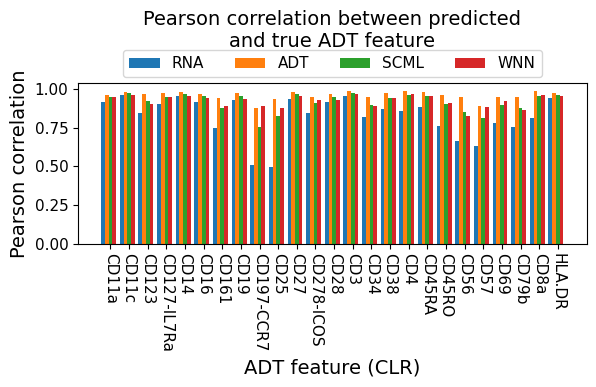

In [30]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
width = 0.2

l1 = plt.bar(x=[i for i in range(rna_sim_adt_corr.shape[0])],
              height=rna_sim_adt_corr[:, 0], width=width, align="edge")
l2 = plt.bar(x=[i + width for i in range(adt_sim_adt_corr.shape[0])],
              height=adt_sim_adt_corr[:, 0], width=width, align="edge")
l3 = plt.bar(x=[i + 2*width for i in range(scml_sim_adt_corr.shape[0])],
             height=scml_sim_adt_corr[:, 0], width=width, align="edge")
l4 = plt.bar(x=[i + 3*width for i in range(wnn_adt_corr.shape[0])],
             height=wnn_adt_corr[:, 0], width=width, align="edge")

ax.legend(handles=[l1, l2, l3, l4], labels=["RNA", "ADT", "SCML", "WNN"],
          ncol=5, bbox_to_anchor=(0.5, 1.12), loc='center')

ax.set_xlabel("ADT feature (CLR)", fontsize=14)
ax.set_ylabel("Pearson correlation", fontsize=14)
ax.set_title("Pearson correlation between predicted\nand true ADT feature", fontsize=14, pad=26)
plt.xticks(np.arange(25)+(5/2)*width, 
    ['CD11a', 'CD11c', 'CD123', 'CD127-IL7Ra', 'CD14', 'CD16', 'CD161',
     'CD19', 'CD197-CCR7', 'CD25', 'CD27', 'CD278-ICOS', 'CD28', 'CD3',
     'CD34', 'CD38', 'CD4', 'CD45RA', 'CD45RO', 'CD56', 'CD57', 'CD69',
     'CD79b', 'CD8a', 'HLA.DR'], 
    rotation=-90);

plt.tight_layout()
plt.savefig("../../sc-spectrum-figures/bmnc/figure-adt-feature-reconstruction-update.pdf", format="pdf", transparent=True)

#### Plot Spearman correlation between predicted and true features

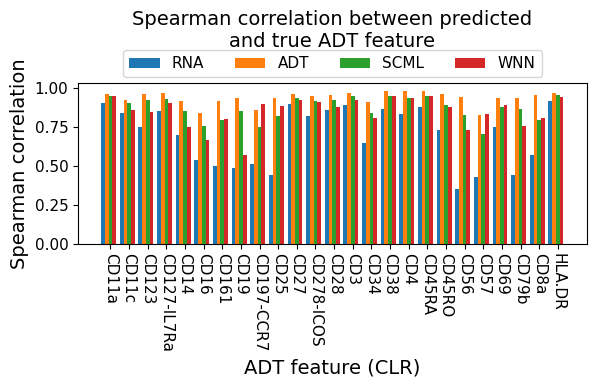

In [31]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
width = 0.2

l1 = plt.bar(x=[i for i in range(rna_sim_adt_corr.shape[0])],
              height=rna_sim_adt_corr[:, 1], width=width, align="edge")
l2 = plt.bar(x=[i + width for i in range(adt_sim_adt_corr.shape[0])],
              height=adt_sim_adt_corr[:, 1], width=width, align="edge")
l3 = plt.bar(x=[i + 2*width for i in range(scml_sim_adt_corr.shape[0])],
             height=scml_sim_adt_corr[:, 1], width=width, align="edge")
l4 = plt.bar(x=[i + 3*width for i in range(wnn_adt_corr.shape[0])],
             height=wnn_adt_corr[:, 1], width=width, align="edge")

ax.legend(handles=[l1, l2, l3, l4], labels=["RNA", "ADT", "SCML", "WNN"],
          ncol=5, bbox_to_anchor=(0.5, 1.12), loc='center')

ax.set_xlabel("ADT feature (CLR)", fontsize=14)
ax.set_ylabel("Spearman correlation", fontsize=14)
ax.set_title("Spearman correlation between predicted\nand true ADT feature", fontsize=14, pad=26)
plt.xticks(np.arange(25)+(5/2)*width, 
    ['CD11a', 'CD11c', 'CD123', 'CD127-IL7Ra', 'CD14', 'CD16', 'CD161',
     'CD19', 'CD197-CCR7', 'CD25', 'CD27', 'CD278-ICOS', 'CD28', 'CD3',
     'CD34', 'CD38', 'CD4', 'CD45RA', 'CD45RO', 'CD56', 'CD57', 'CD69',
     'CD79b', 'CD8a', 'HLA.DR'], 
    rotation=-90);

plt.tight_layout()
plt.savefig("../../sc-spectrum-figures/bmnc/figure-adt-feature-reconstruction-Spearman-update.pdf", format="pdf", transparent=True)